In [1]:
import sys, os
sys.path.append(os.path.abspath("../"))

In [2]:
from art_enrich import lib as tab

In [3]:
tab.detailed_enrichment_init()

In [4]:
from collections import defaultdict
import numpy as np
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate

import betterplotlib as bpl
bpl.presentation_style()

In [5]:
bpl.presentation_style()

In [6]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.1, 50, total_mass=1)

First try to see if the integration is okay.

In [7]:
frac_E = 3.25E49  # ergs / solar mass
# frac_N_SN = 0.0109743508039993  # SN / solar mass

In [8]:
frac_N_SN = integrate.quad(imf.normalized_dn_dm, 8.0, 50.0)[0]

In [9]:
integrate.quad(imf.normalized_dn_dm, 0.1, 50.0)[0]

1.6386543349407943

In [10]:
tab.imf_integral_py(0.1, 50.0)

1.6386543355363412

In [11]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 0.9, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = tab.imf_integral_py(m_low, m_high)
    
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.3f} {:.3f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

In [12]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 50.0, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = tab.imf_integral_py(m_low, m_high)
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.1f} {:.1f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

Then attempt to build a SN history

In [13]:
dt = 1E3

In [14]:
times = np.arange(3E6, 50E6, dt)
turnoff_masses = [lt.turnoff_mass(t, 0.02) for t in times]

In [50]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe", "Z", "total"]
all_fields = elts + ["E", "N_SN", "N_SN_left"]
field_idxs = {f:i for i, f in enumerate(all_fields)}

class SNHistory(object):
    def __init__(self, stellar_mass, verbose=False):
        self.mass = stellar_mass
        
        self.fields = all_fields
        self.idxs = field_idxs
        
        self.yields = defaultdict(list)
        self.cumulative = defaultdict(list)
        
        self.handle_history(verbose)
        
    def handle_history(self, verbose=False):
        self.unexploded_sn = 0
        
        for idx in range(len(turnoff_masses) - 1):
            m_now  = turnoff_masses[idx]
            m_next = turnoff_masses[idx+1]
            yields = tab.get_yields_sn_ii_py(self.unexploded_sn, m_now, m_next, self.mass, 0.015)
            
            # handle SN numbers
            self.unexploded_sn = yields[self.idxs["N_SN_left"]]
#             print(m_now, m_next, yields[self.idxs["N_SN"]], self.unexploded_sn)
            if verbose:
                print("{:8.4f} {:8.4f} {:8.4f} {:8.4f}".format(m_now, m_next, yields[self.idxs["N_SN"]], self.unexploded_sn))
            
            
            
            for field in self.fields:
                this_yield = yields[self.idxs[field]]
                self.yields[field].append(this_yield)
                if len(self.cumulative[field]) == 0:
                    self.cumulative[field].append(this_yield)
                else:
                    self.cumulative[field].append(self.cumulative[field][-1] + this_yield)
        

In [51]:
def plot_history(field, mass, n, verbose=False):
    plot_times = times[1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(times)
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    if field == "E":
        label = "E [ergs] Cumulative"
    else: 
        label = field + " Cumulative"
    ax.add_labels("Age [yr]", label)
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$", "lower right")
    
    if field == "E":
        ax.axhline(frac_E * mass, ls=":")
    if field == "N_SN":
        expected = frac_N_SN * mass
        ax.axhline(expected, ls=":")
        ax.add_text(left_limit, expected, "{:.3f}".format(expected), 
                    ha="left", va="bottom", fontsize=13)
    
    for i in range(n):
        this_obj = SNHistory(mass, verbose)
        ax.plot(plot_times, this_obj.cumulative[field])
        if i == 0 and field == "N_SN":  # first time only
            true = this_obj.cumulative[field][-1]
            ax.add_text(right_limit, true, "{:.3f}".format(true), 
                        ha="right", va="bottom", fontsize=13)
        
    ax.set_limits(left_limit, right_limit, 0)
    
    fig.savefig("./plots/discrete_{}_m_{:.1e}_dt_{:.1g}.png".format(field, mass, dt))

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


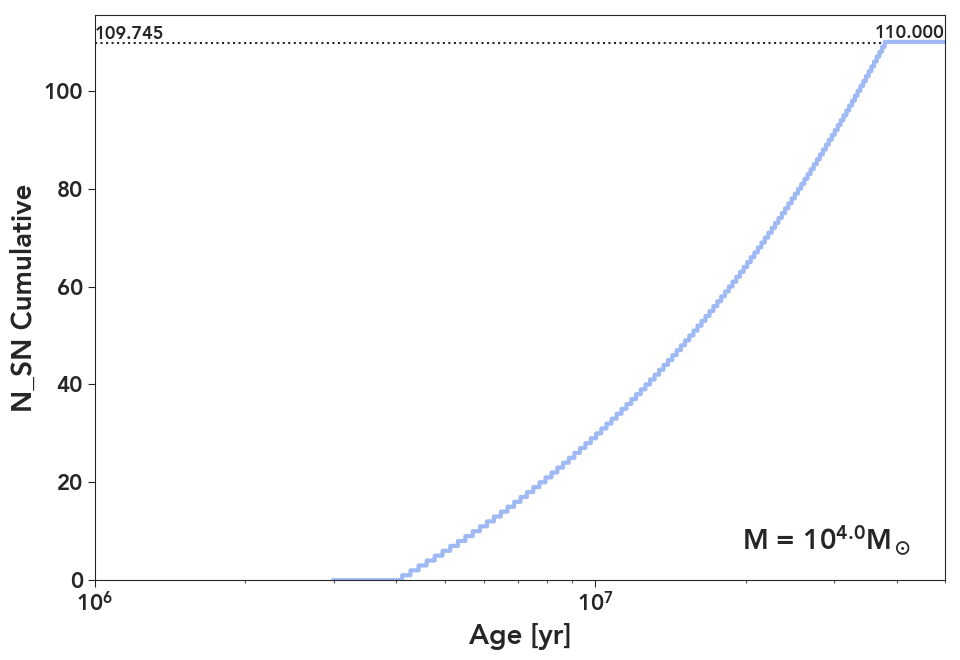

In [52]:
plot_history("N_SN", 10000, 1)

In [18]:
def plot_rates(field, mass, n):
    fig, ax = bpl.subplots()
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    ax.add_labels("Age [yr]", field + " Per Timestep")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "}$", "lower right")
    
    for _ in range(n):
        this_obj = SNHistory(mass)
    
        ax.plot(times[1:], this_obj.yields[field])
    ax.set_limits(1E6, 60E6, 0)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


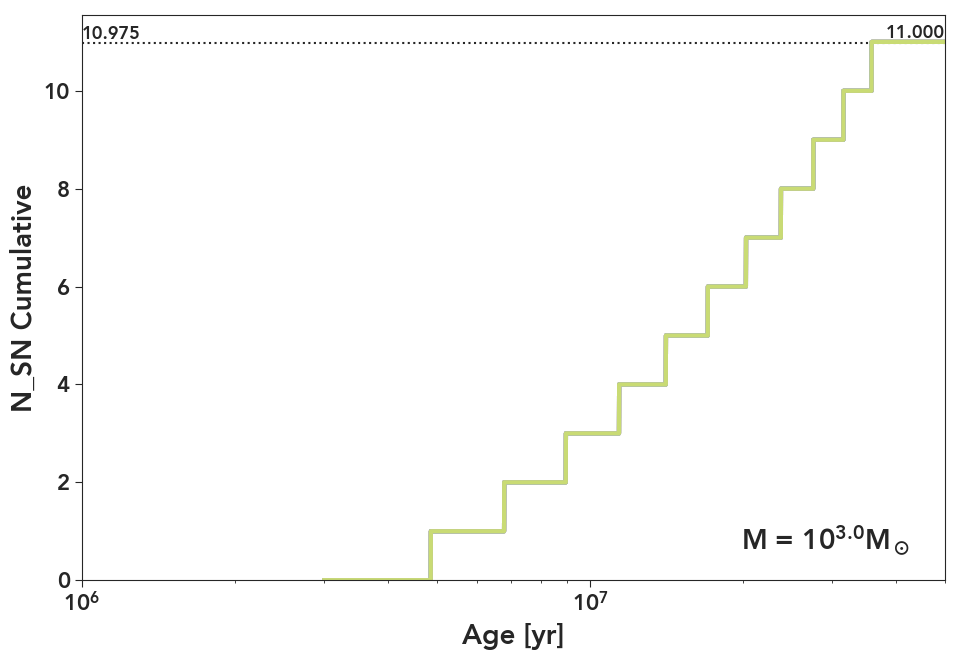

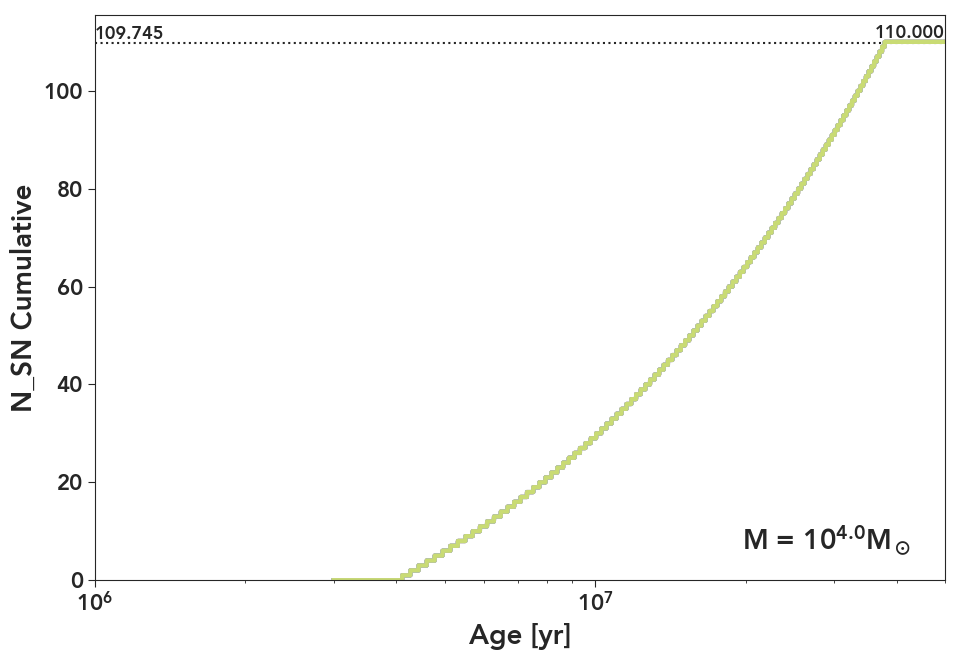

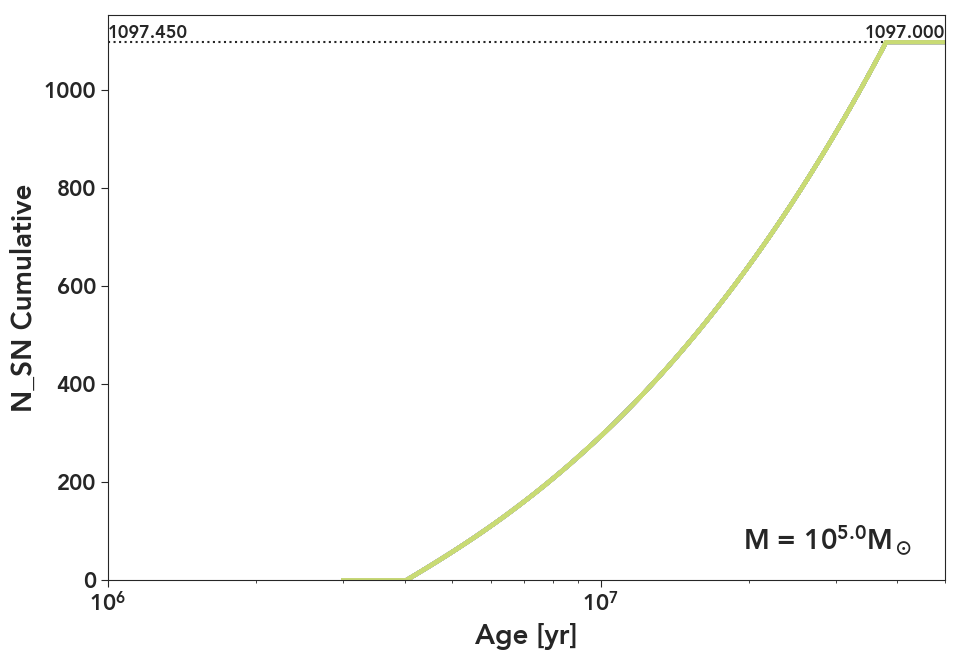

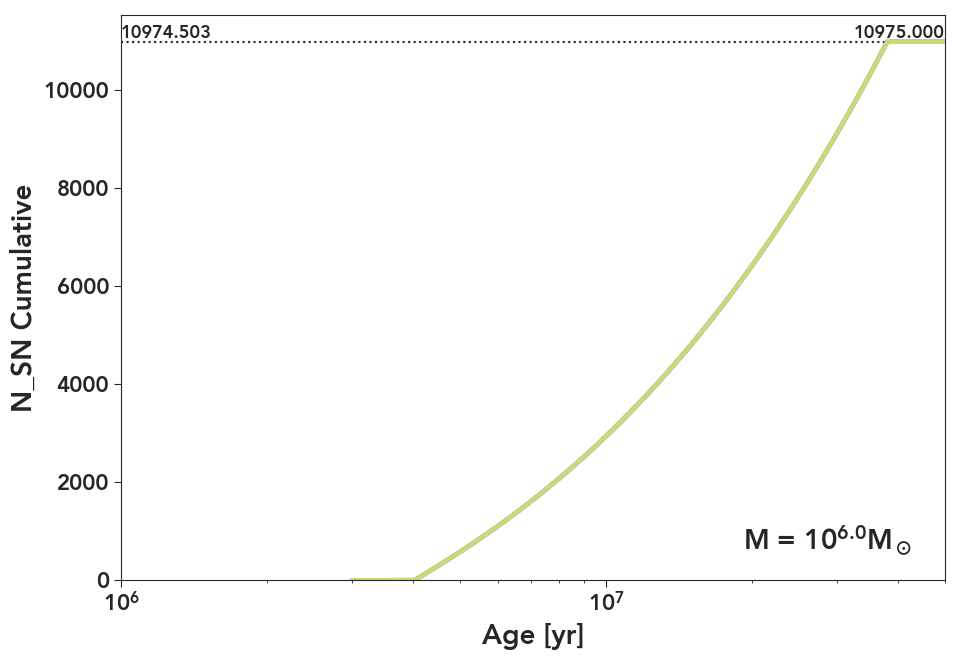

In [19]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N_SN", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


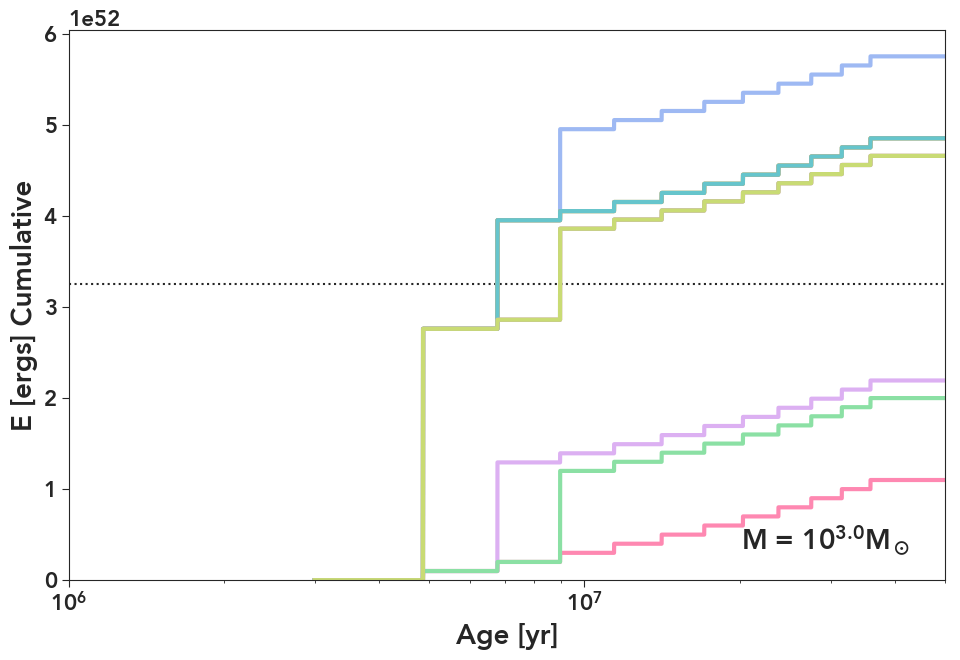

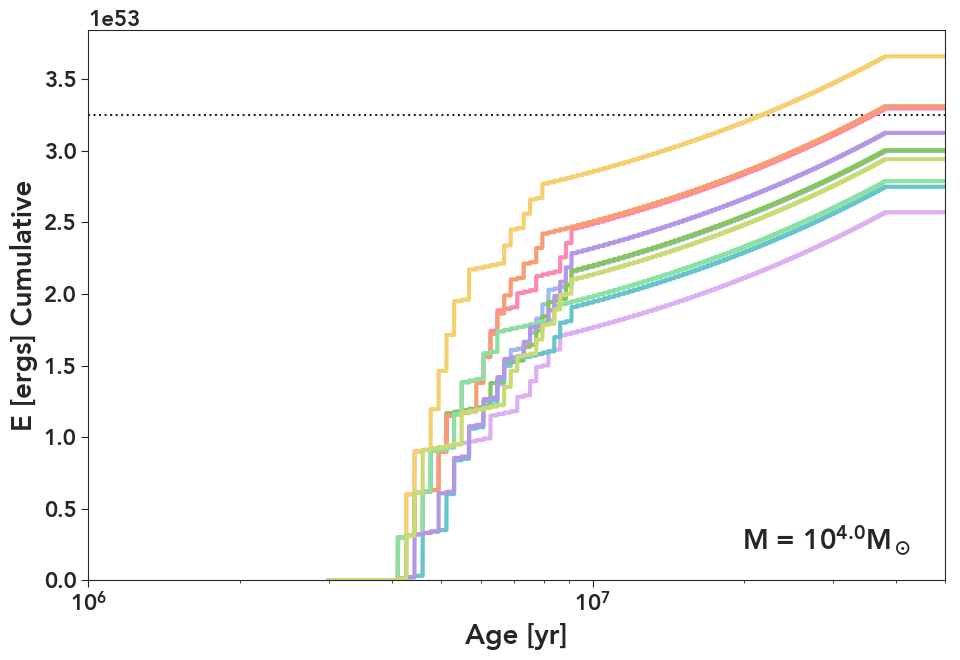

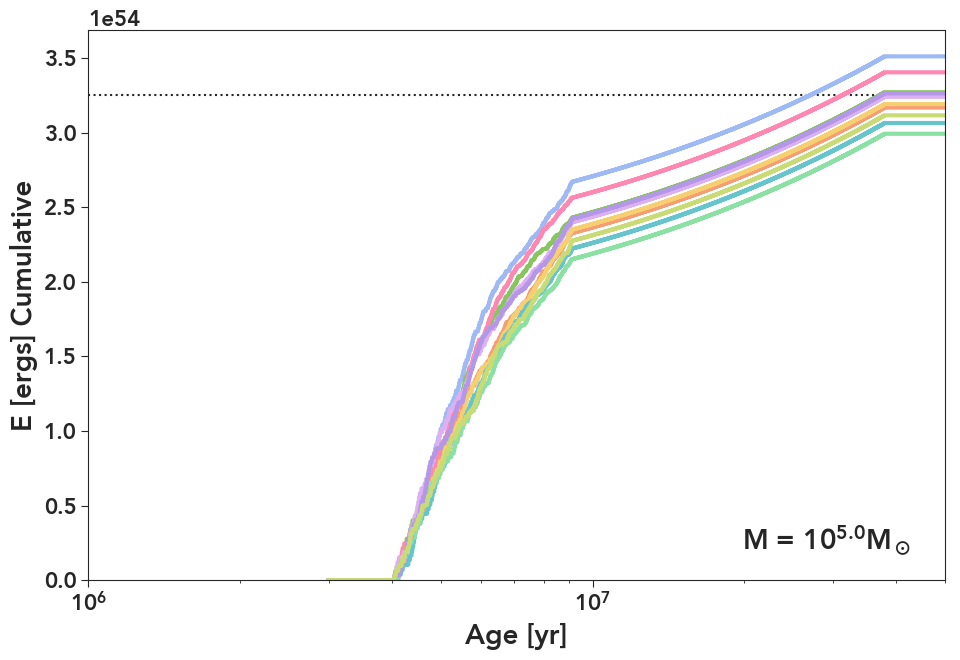

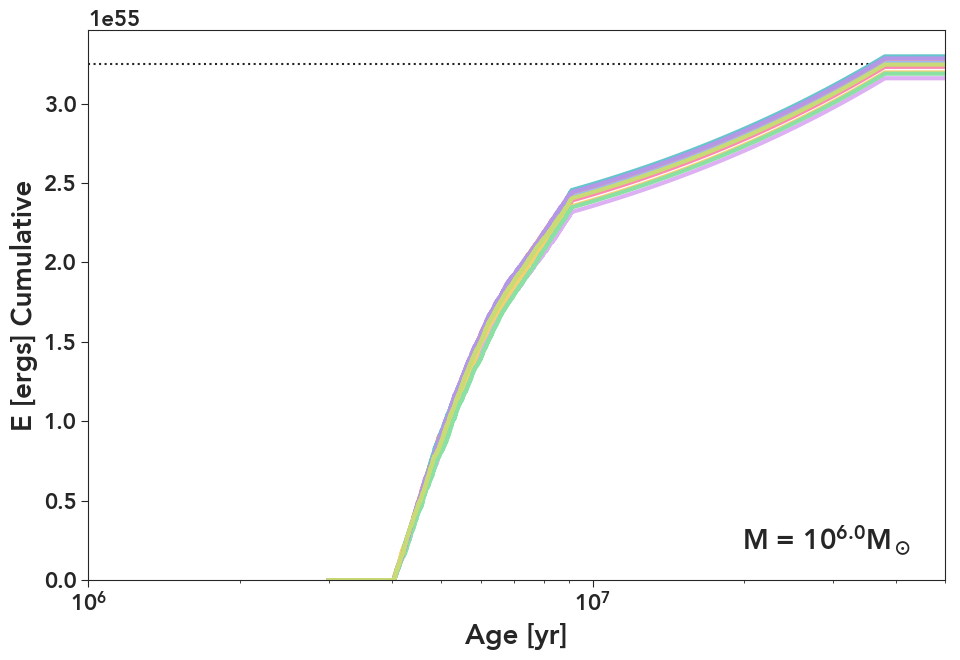

In [54]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("E", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


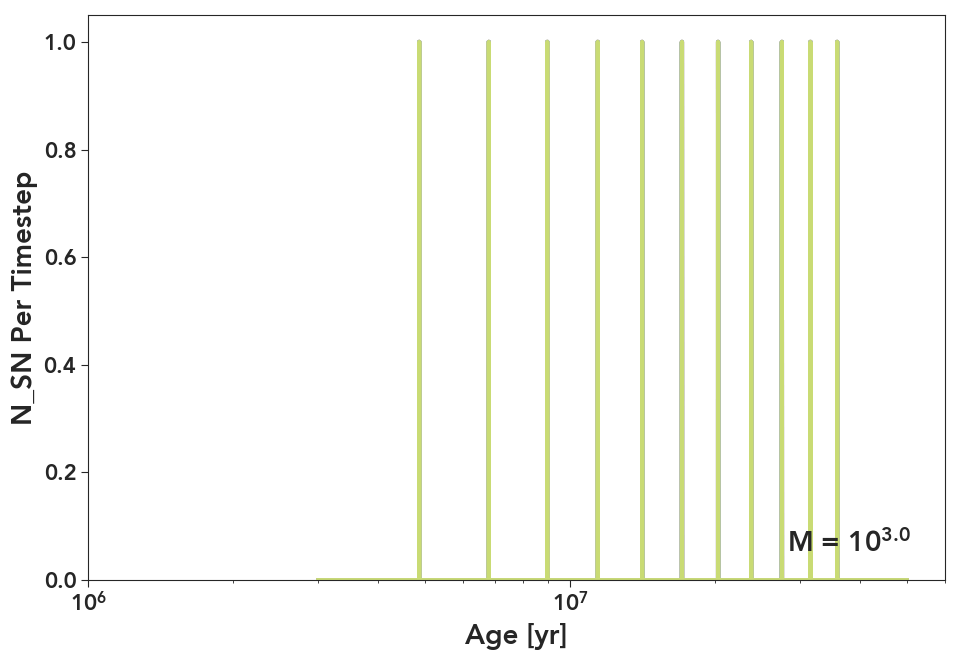

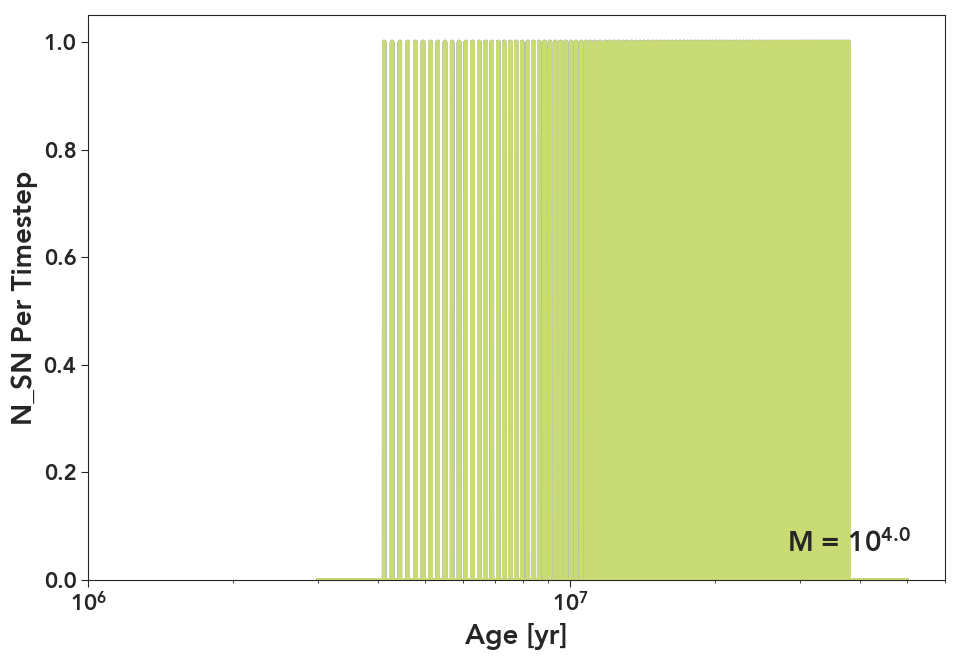

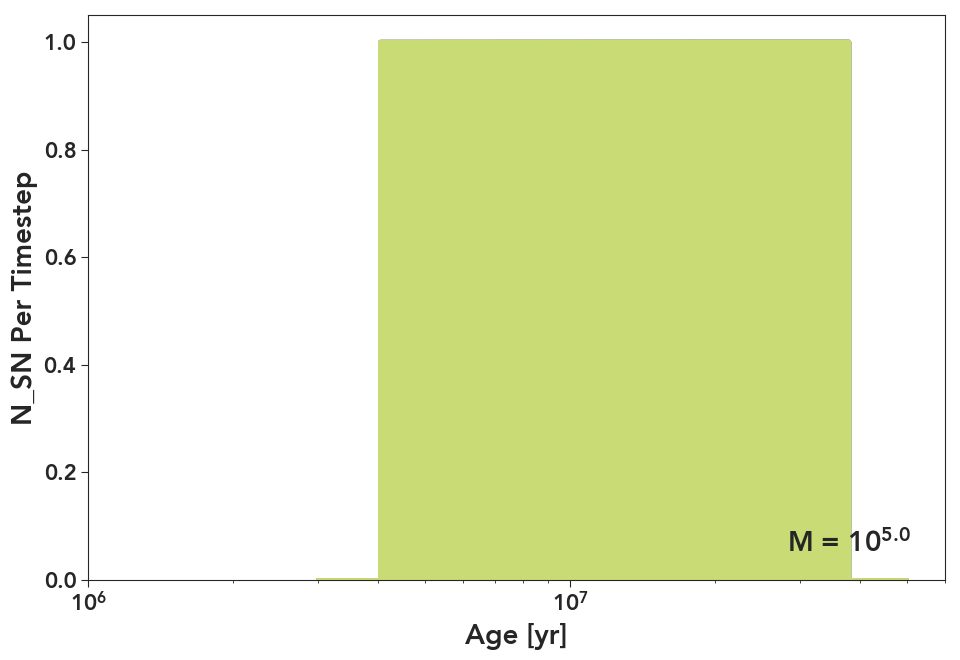

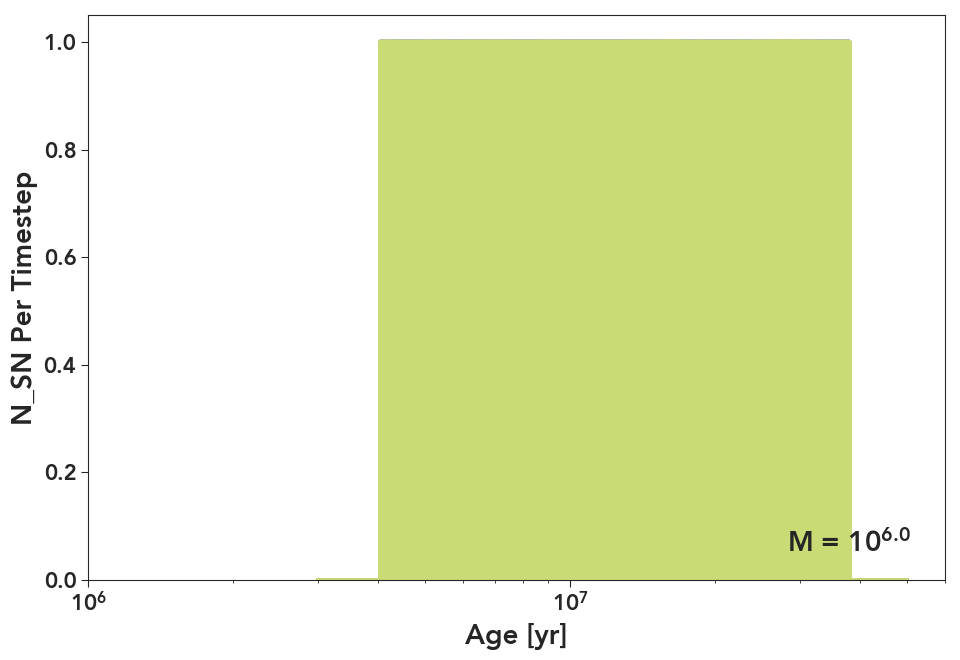

In [21]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_rates("N_SN", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


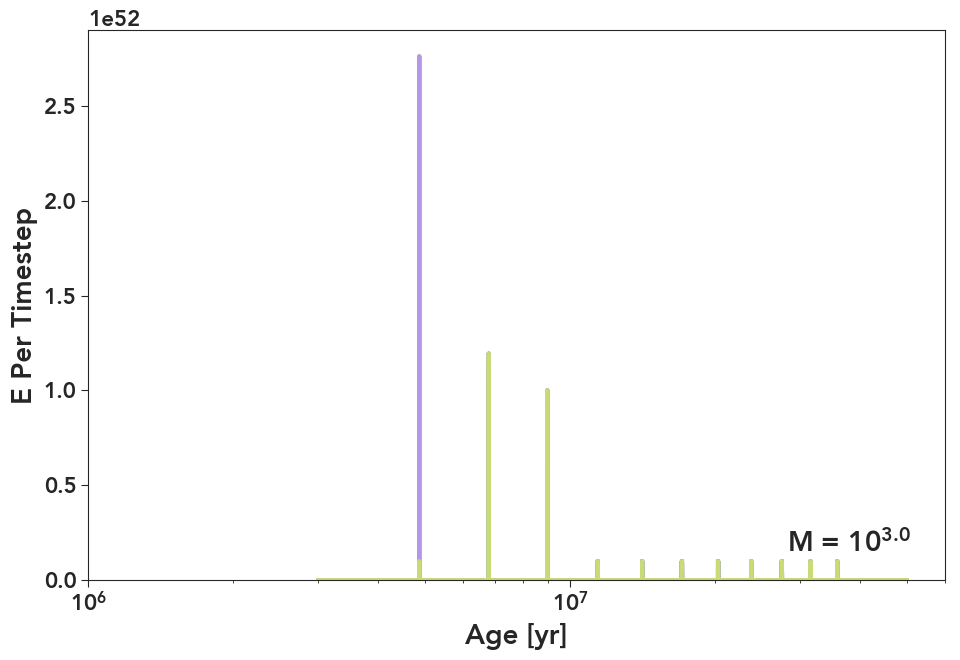

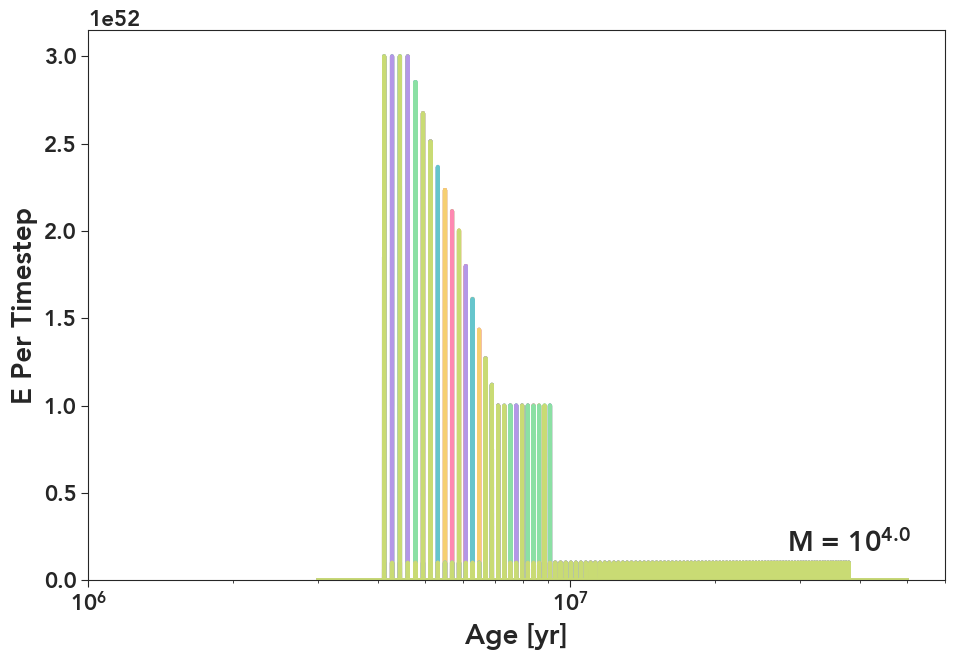

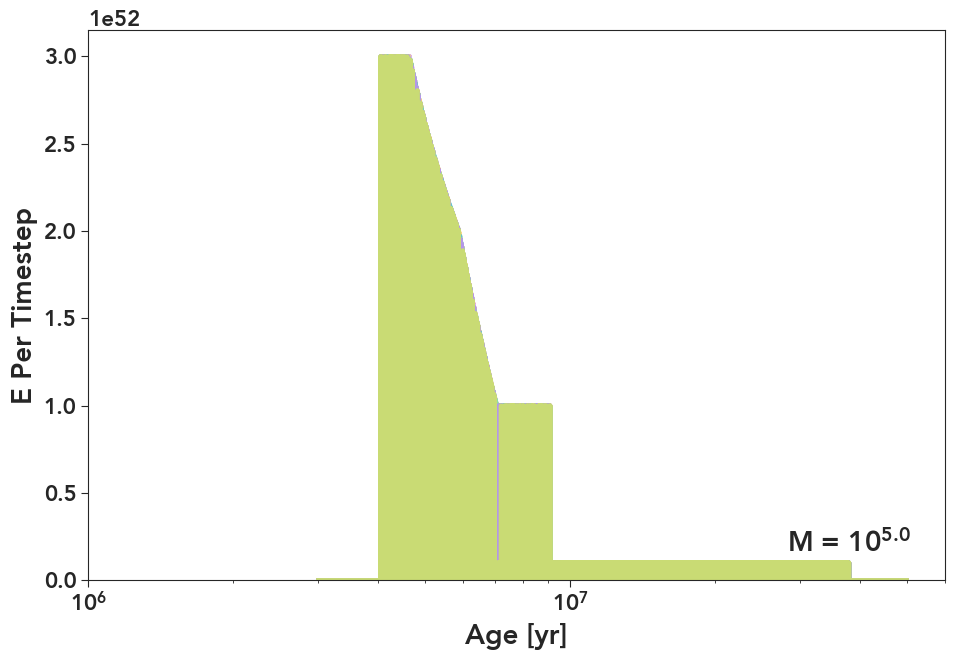

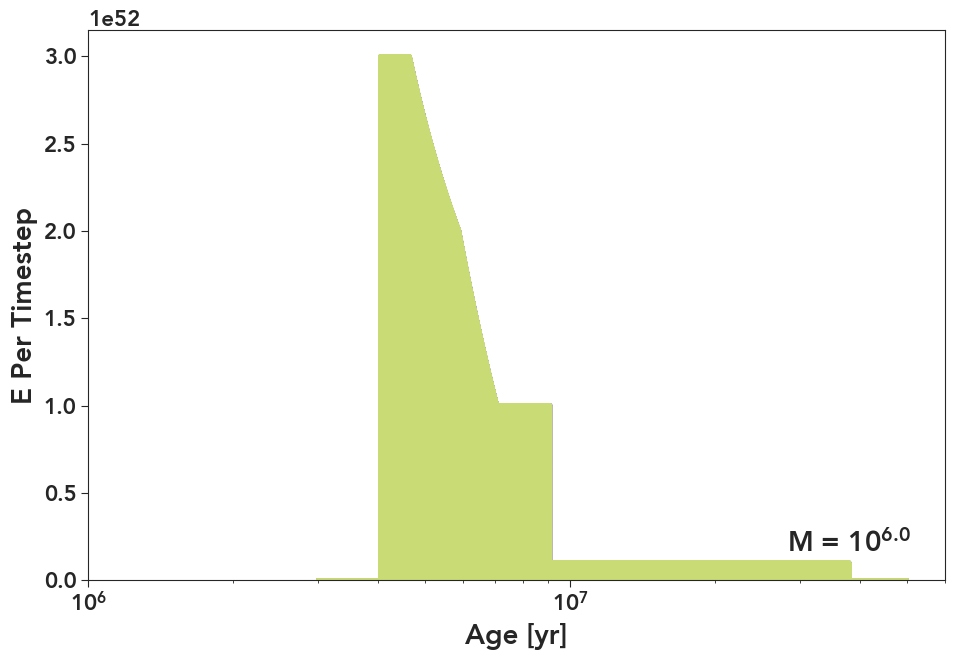

In [22]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_rates("E", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


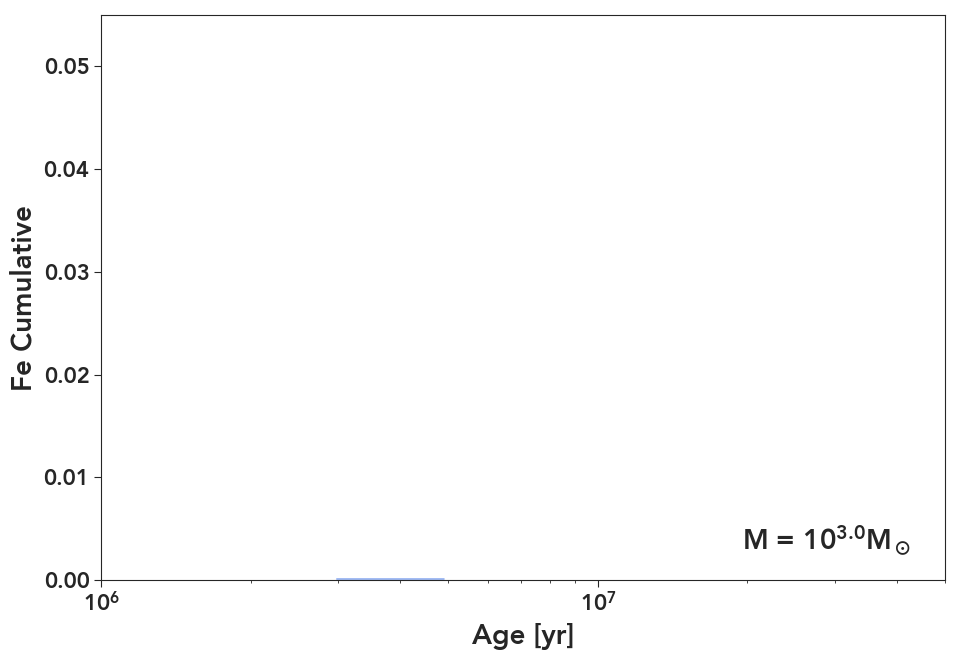

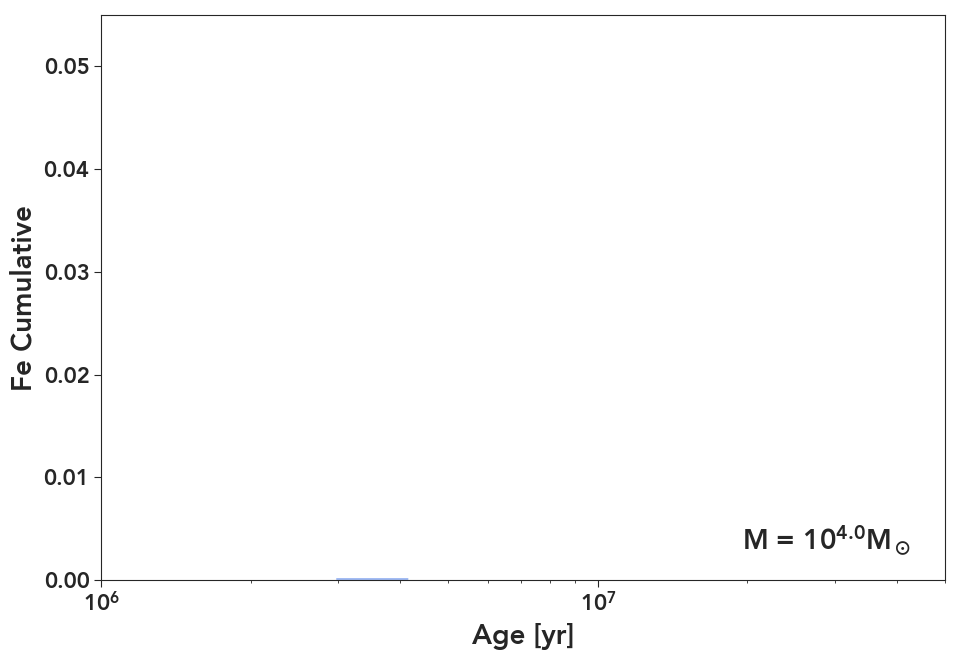

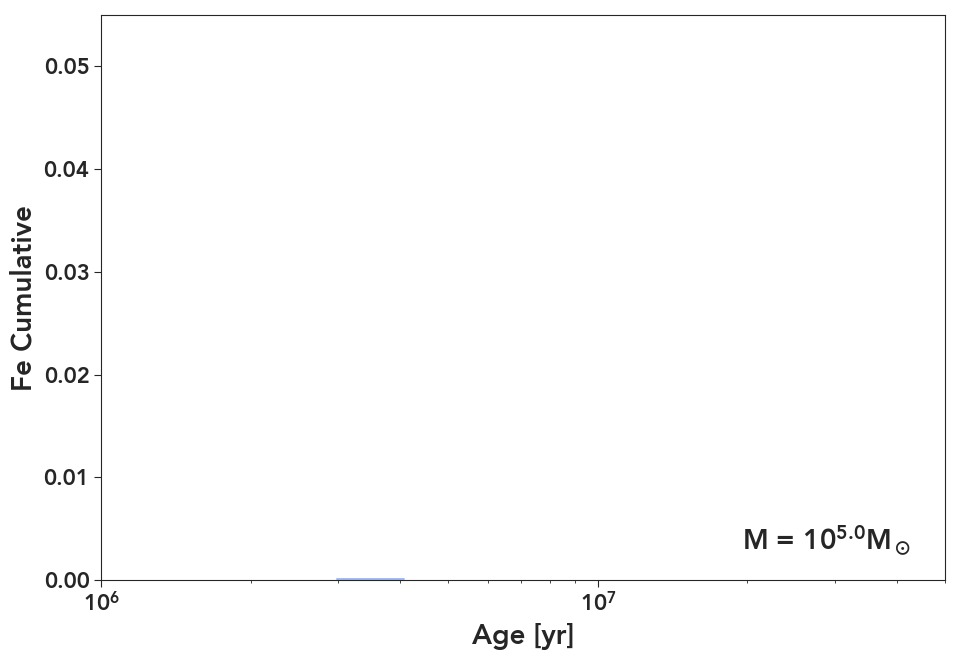

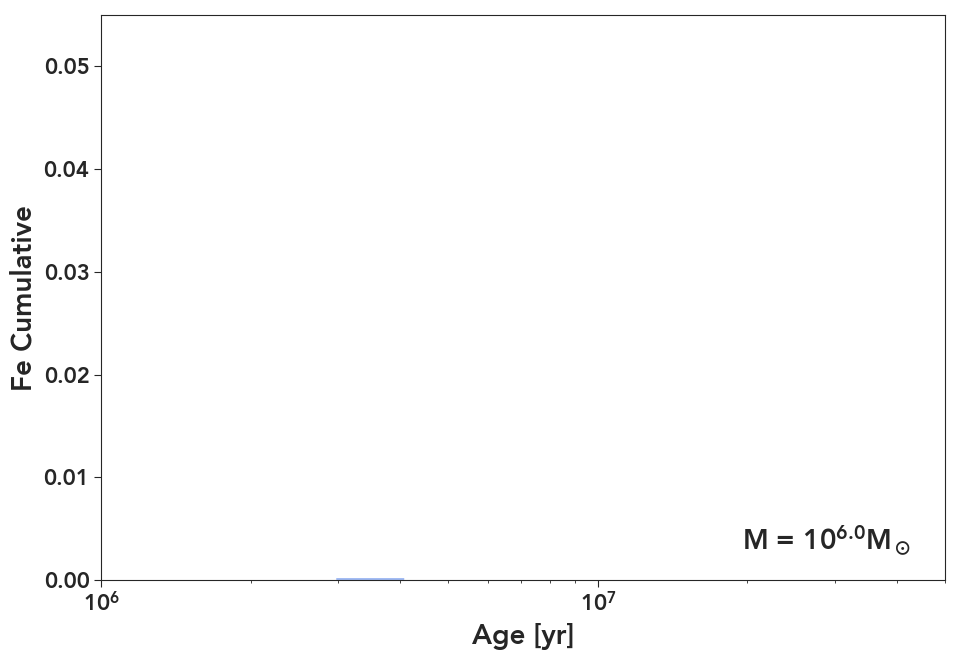

In [56]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("Fe", m, 1)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


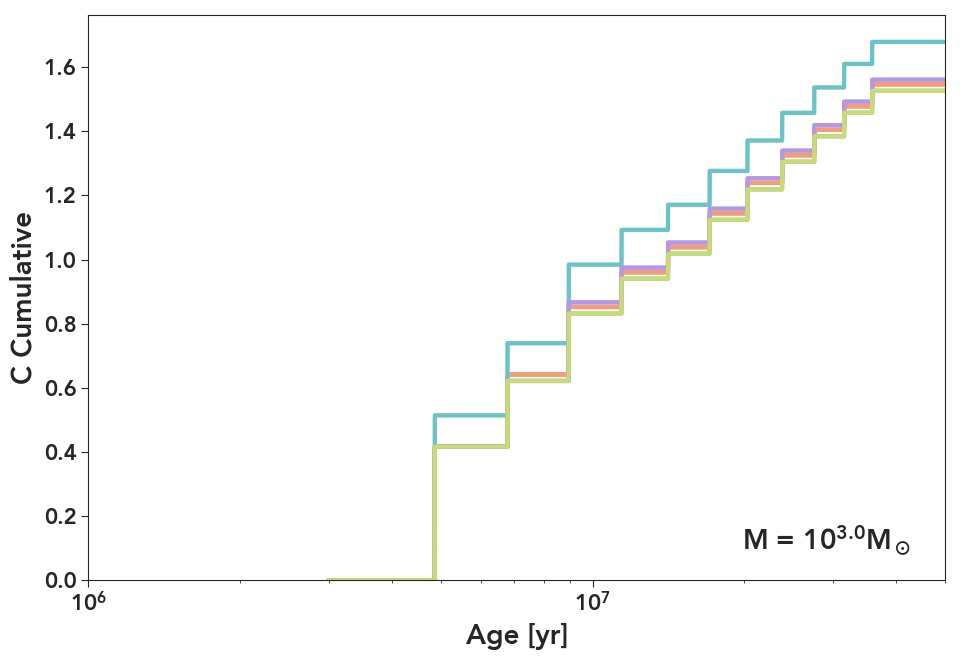

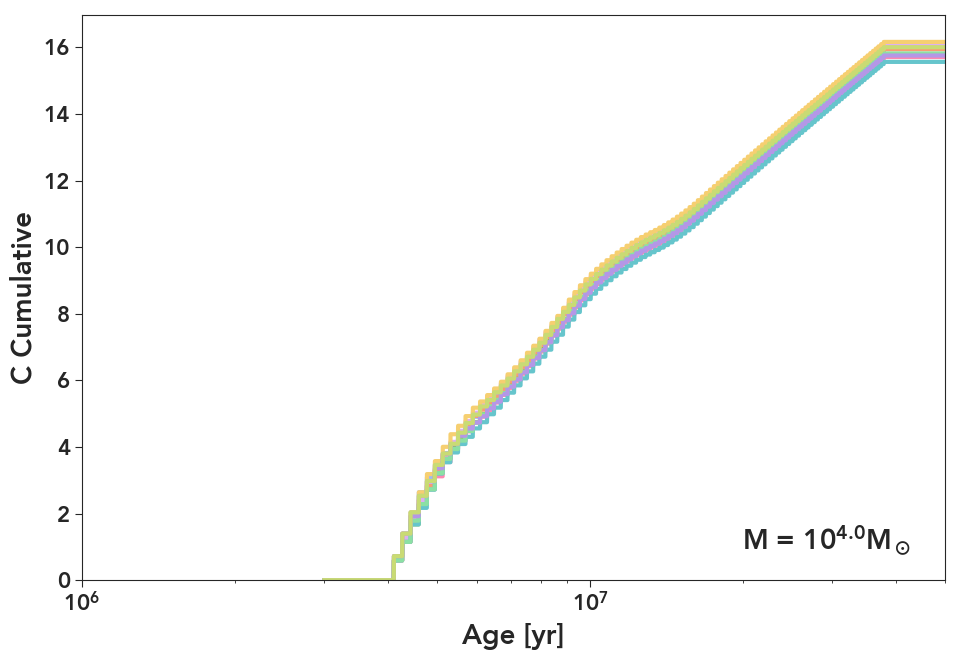

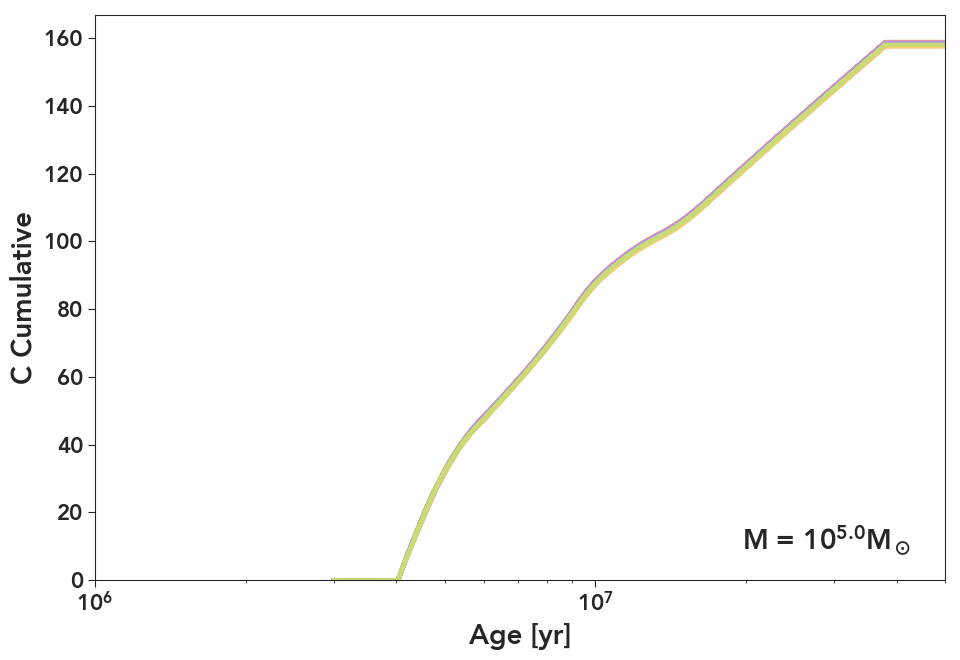

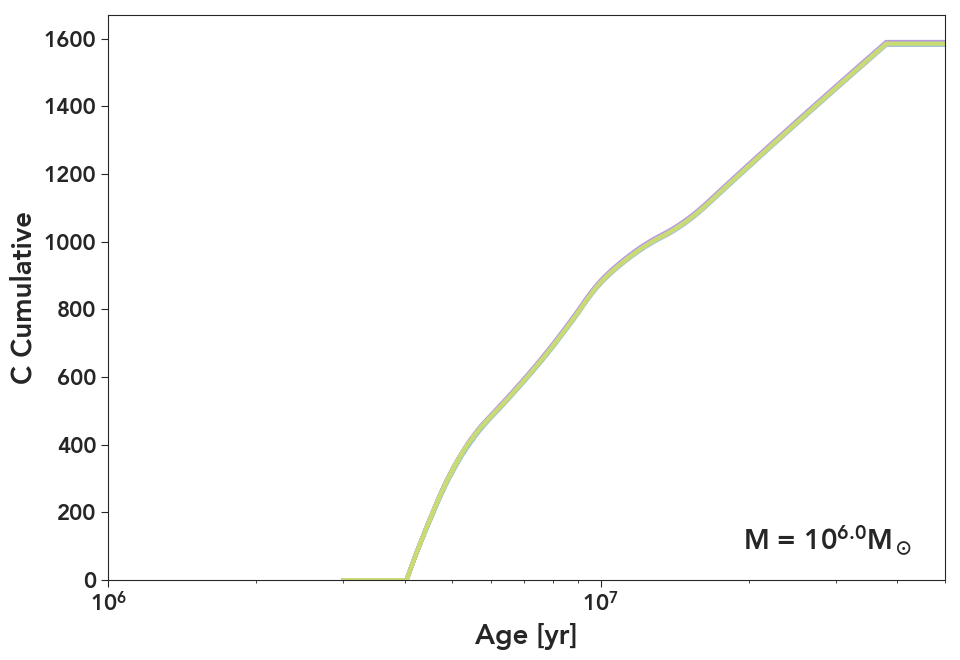

In [24]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("C", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


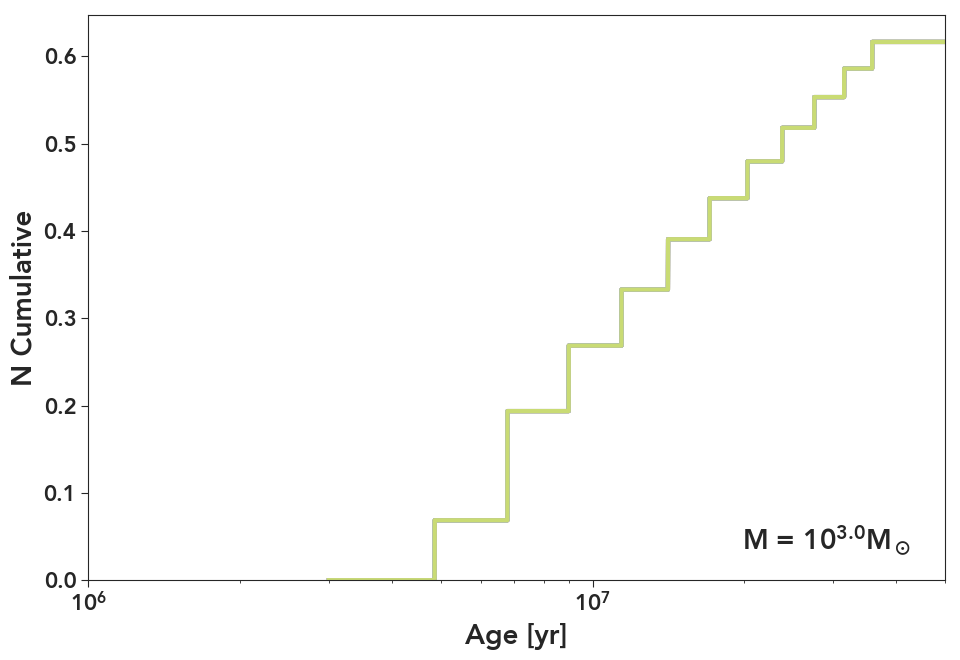

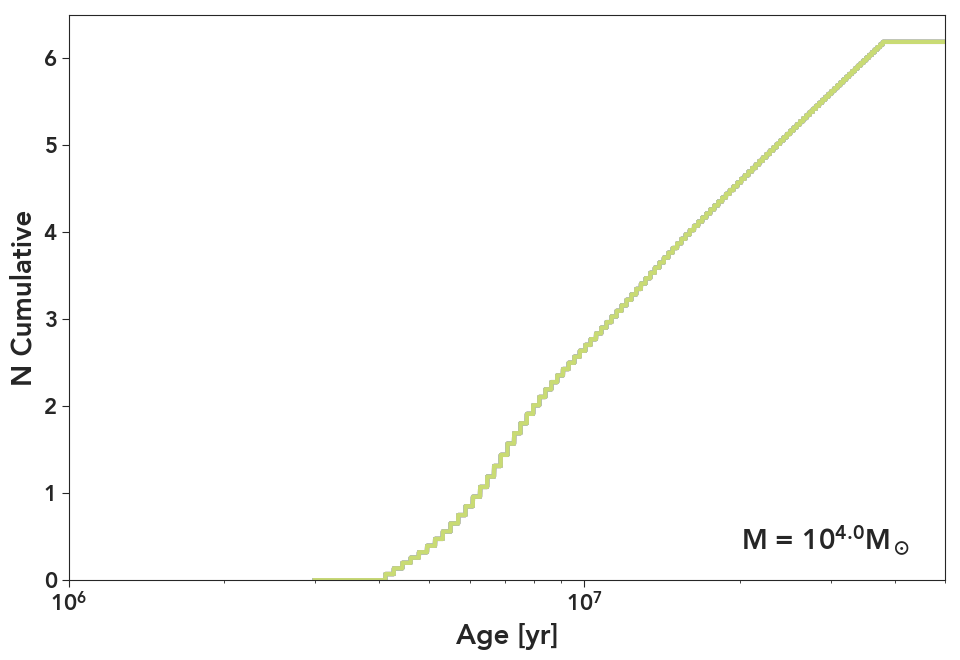

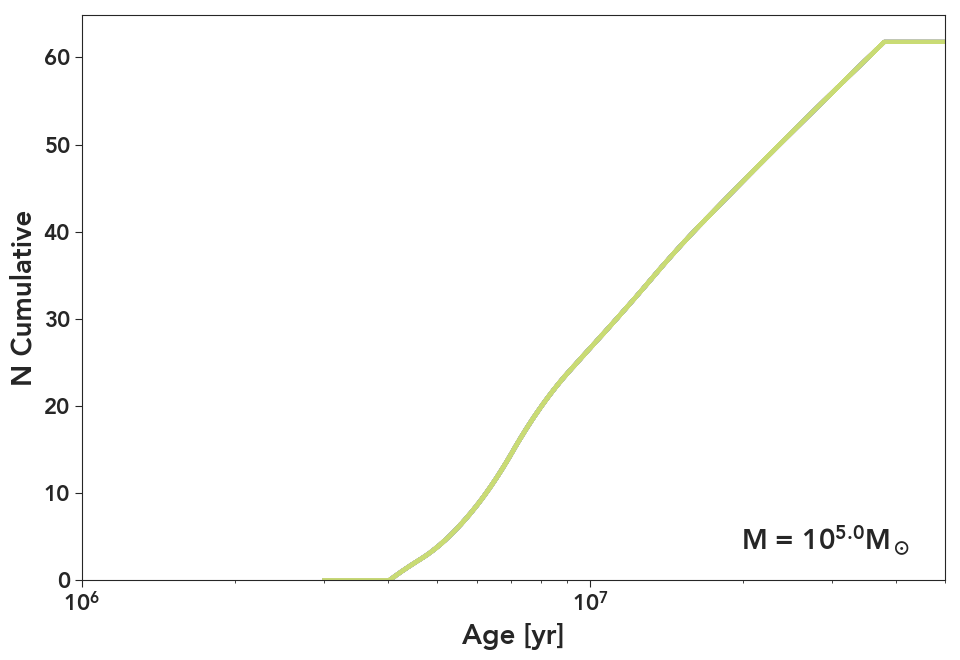

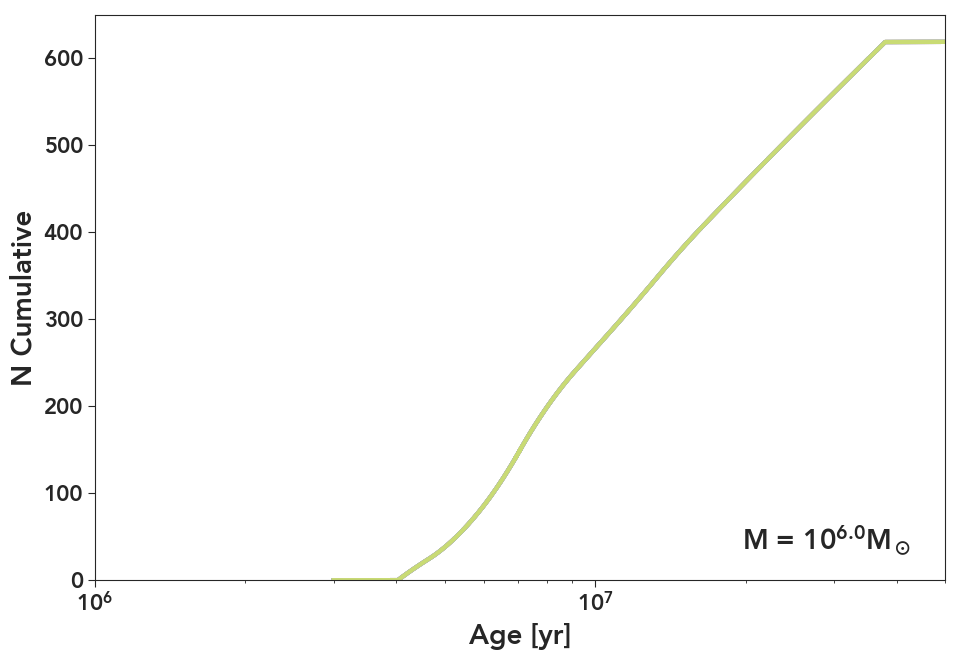

In [25]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N", m, 10)

In [43]:
tab.get_yields_raw_agb_py(0.011, 1.65)[0]

inf

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


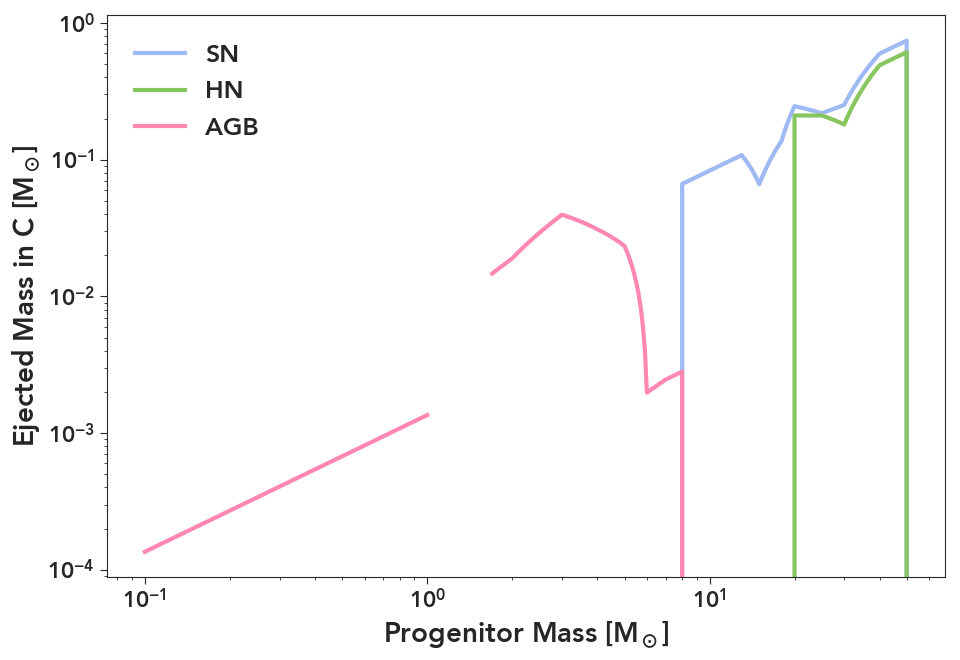

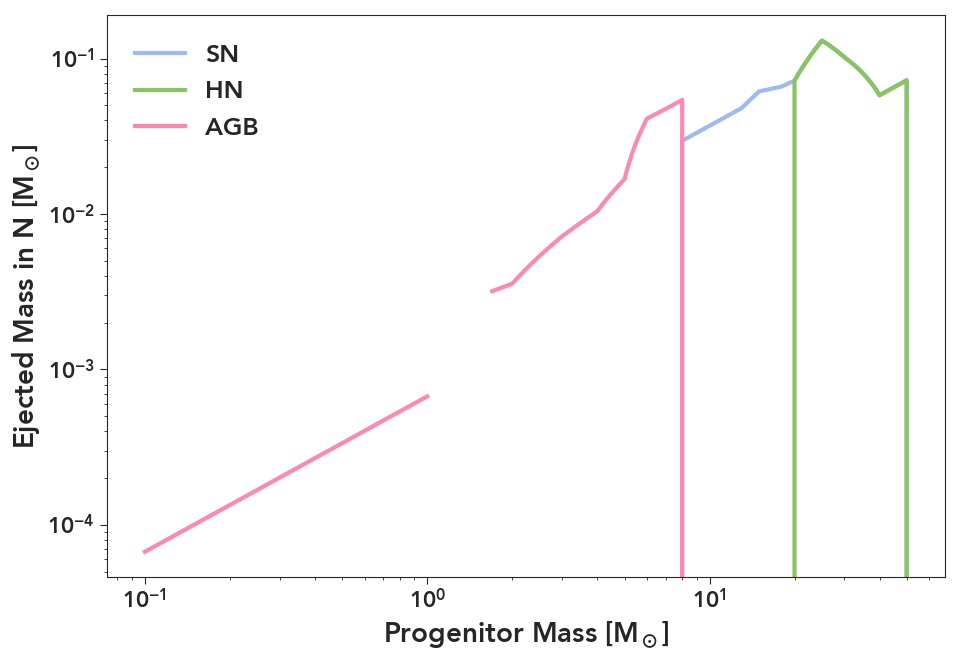

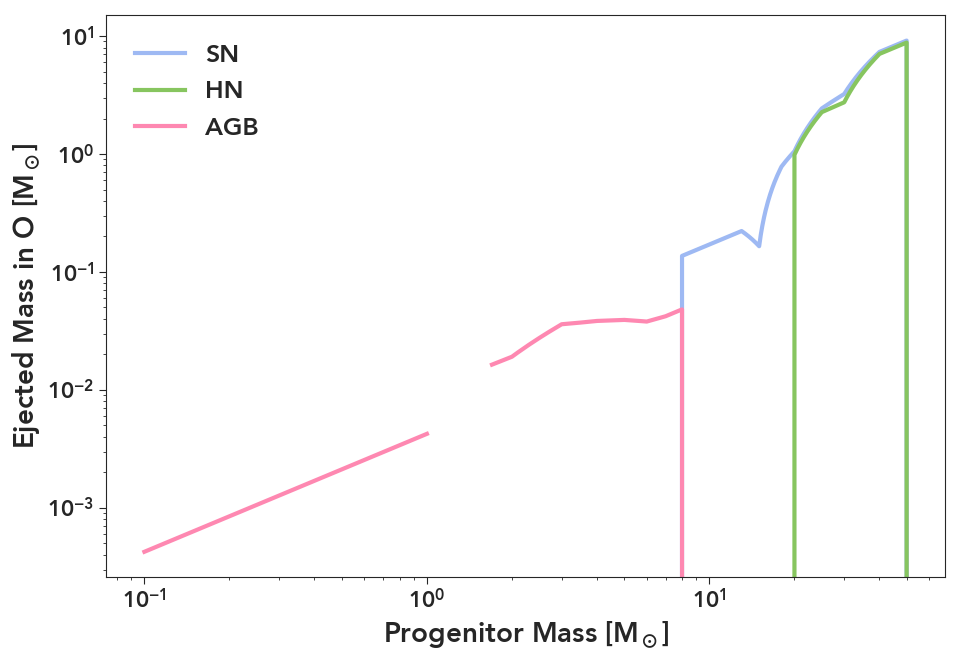

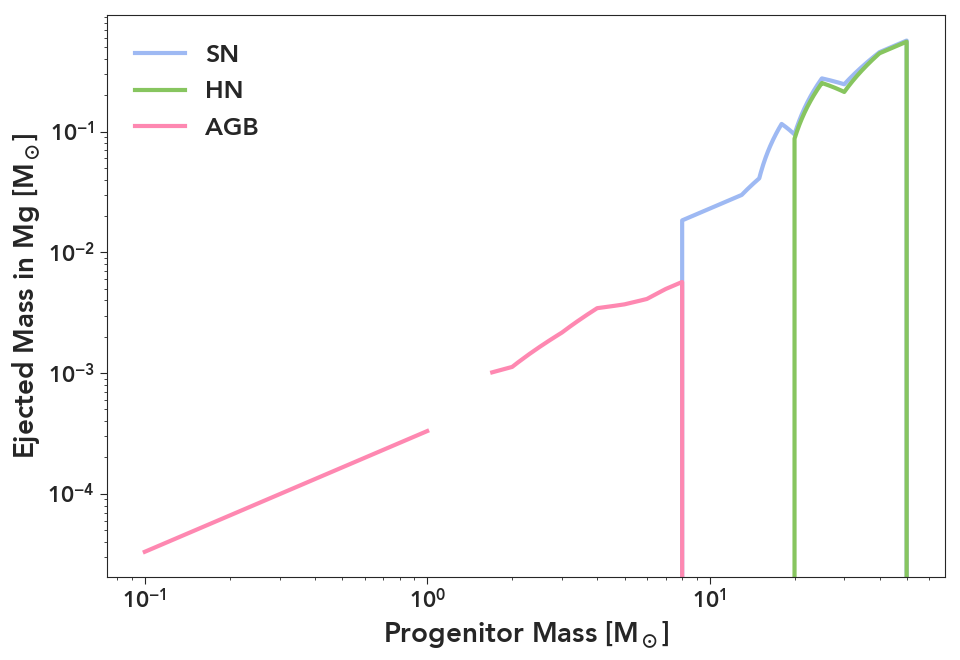

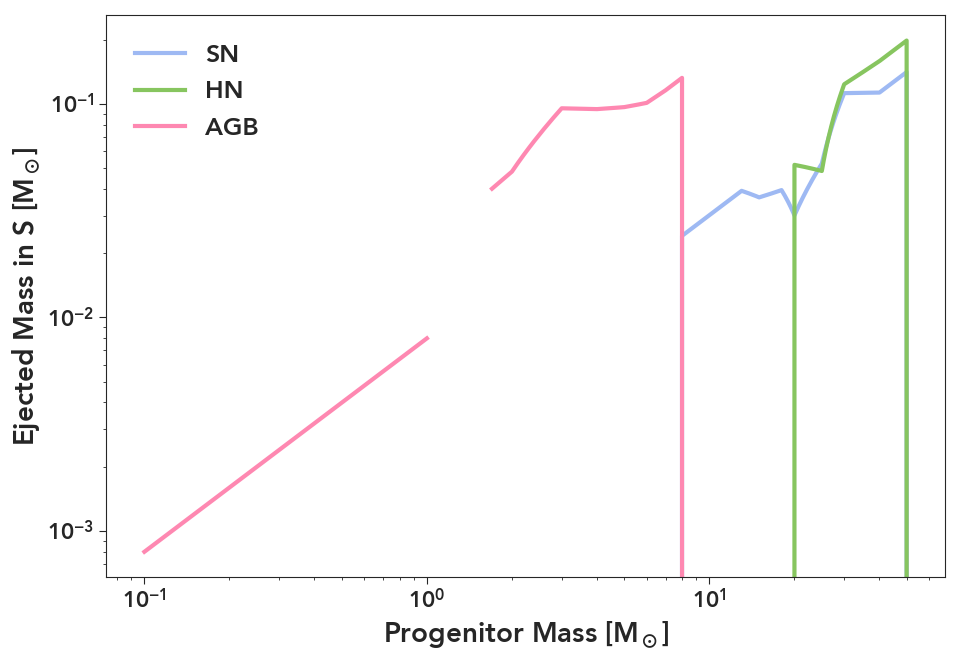

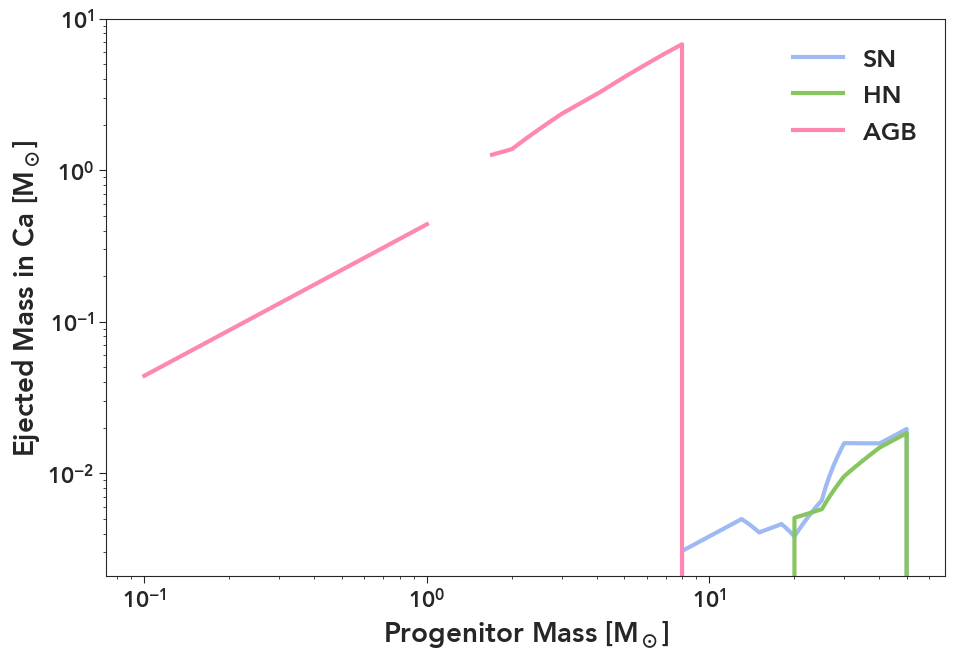

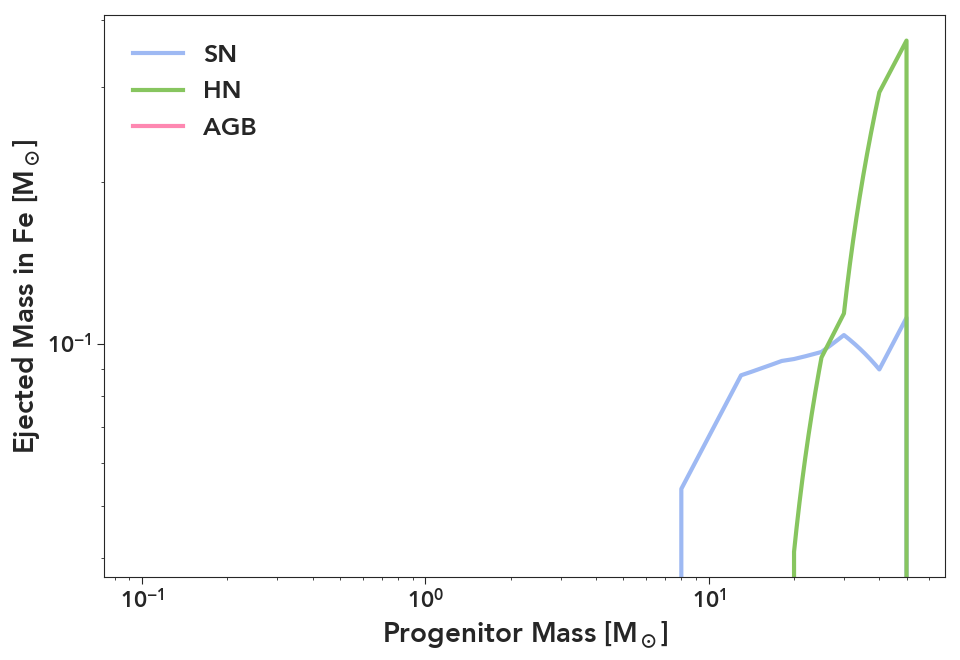

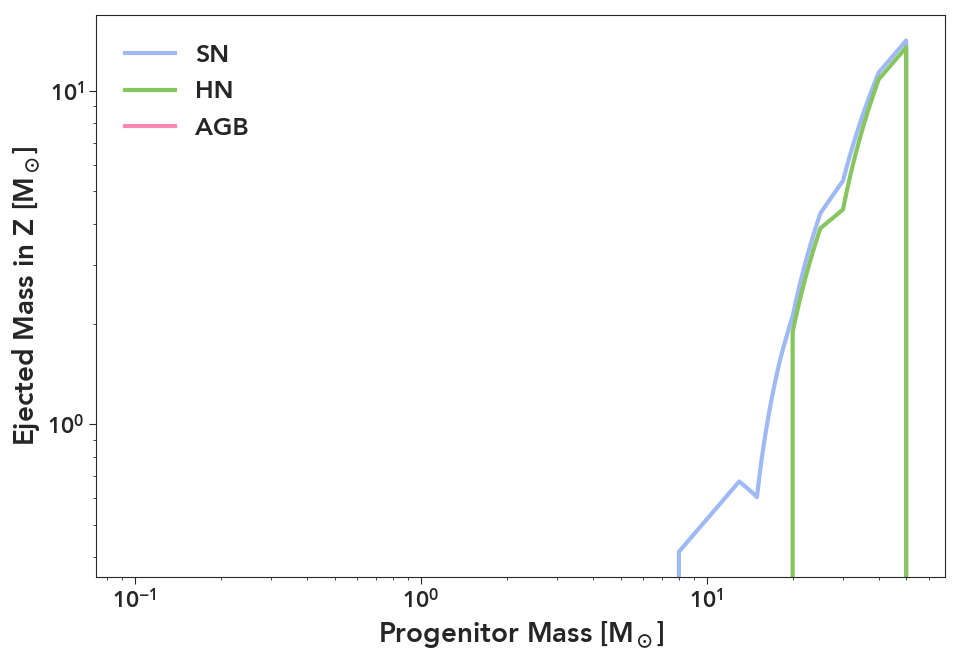

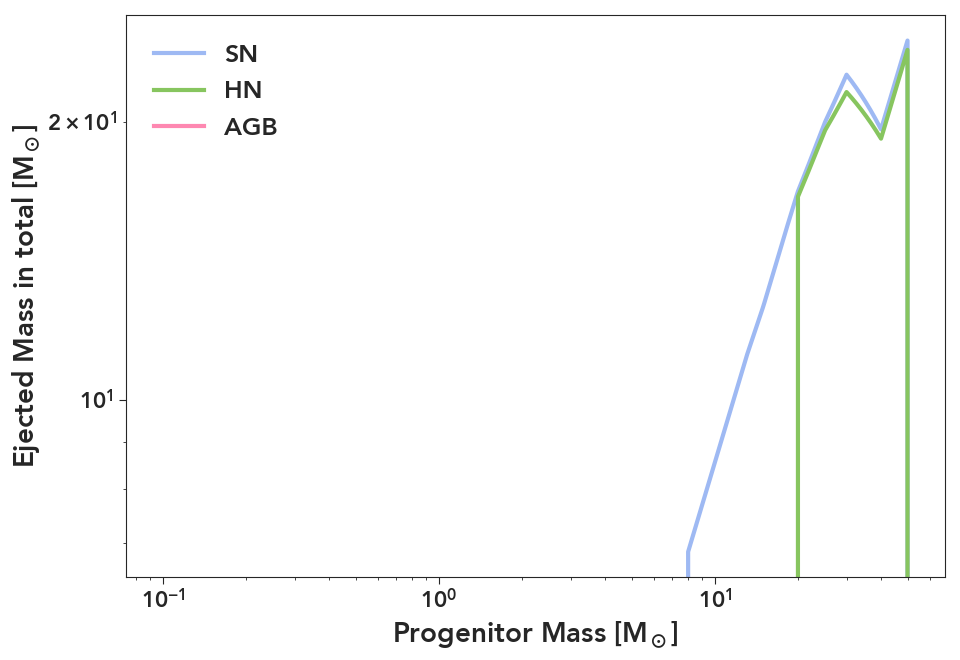

In [44]:
z = 0.02
ms = np.arange(0.1, 50.1, 0.1)
for elt in elts:
    fig, ax = bpl.subplots()
    for func, label in zip([tab.get_yields_raw_sn_ii_py,
                            tab.get_yields_raw_hn_ii_py,
                            tab.get_yields_raw_agb_py], 
                           ["SN", "HN", "AGB"]):
        yields = [func(z, m)[field_idxs[elt]] for m in ms]

        
        ax.plot(ms, yields, label=label)
    
    ax.add_labels("Progenitor Mass [$M_\odot$]", "Ejected Mass in {}".format(elt) + " [$M_\odot$]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()

# These last few things aren't correct since AGB doesn't return all the yields, fix them

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


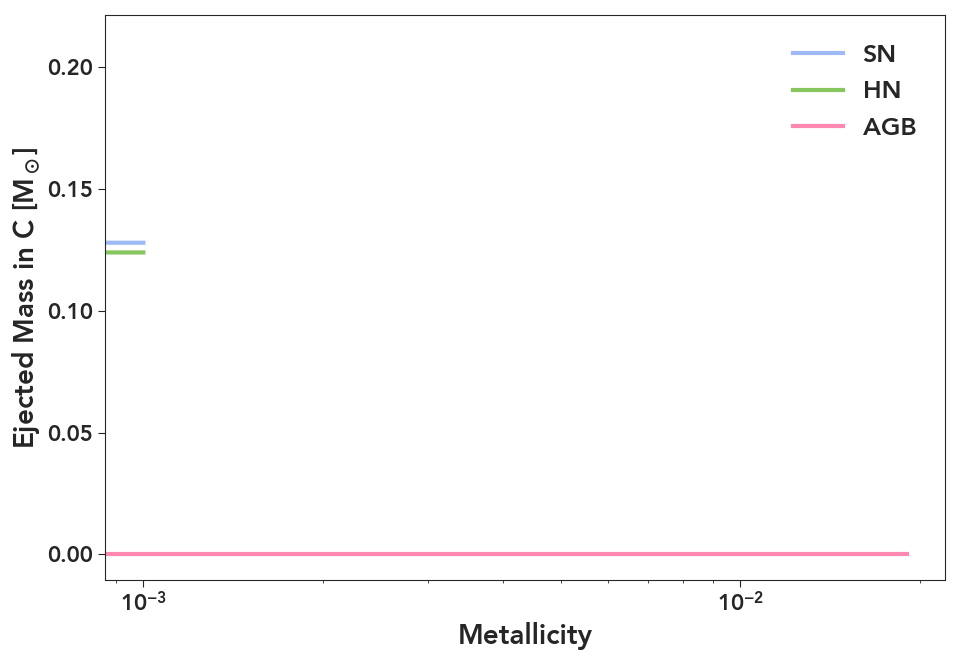

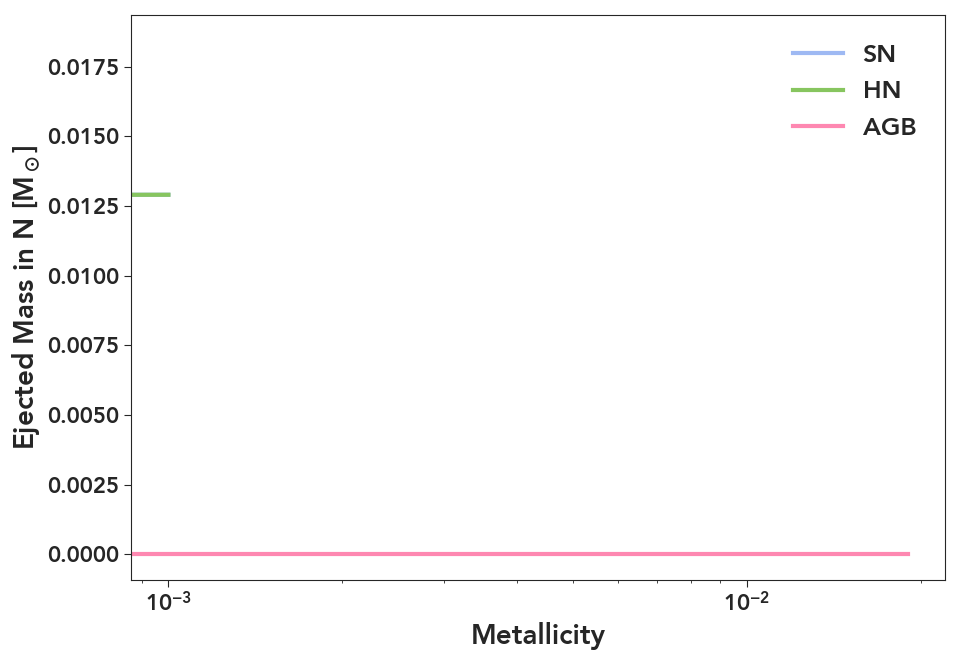

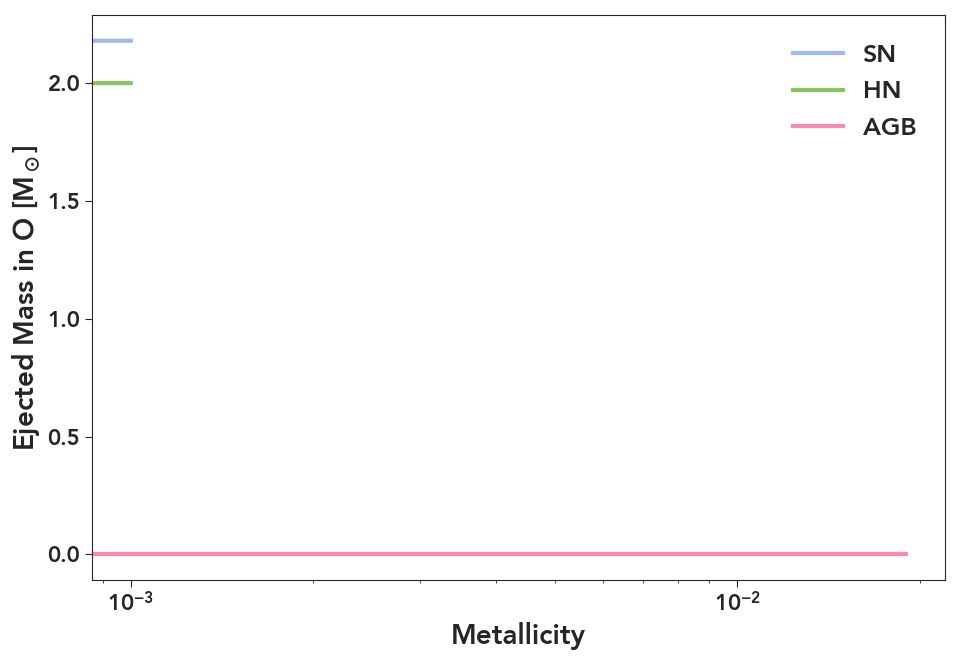

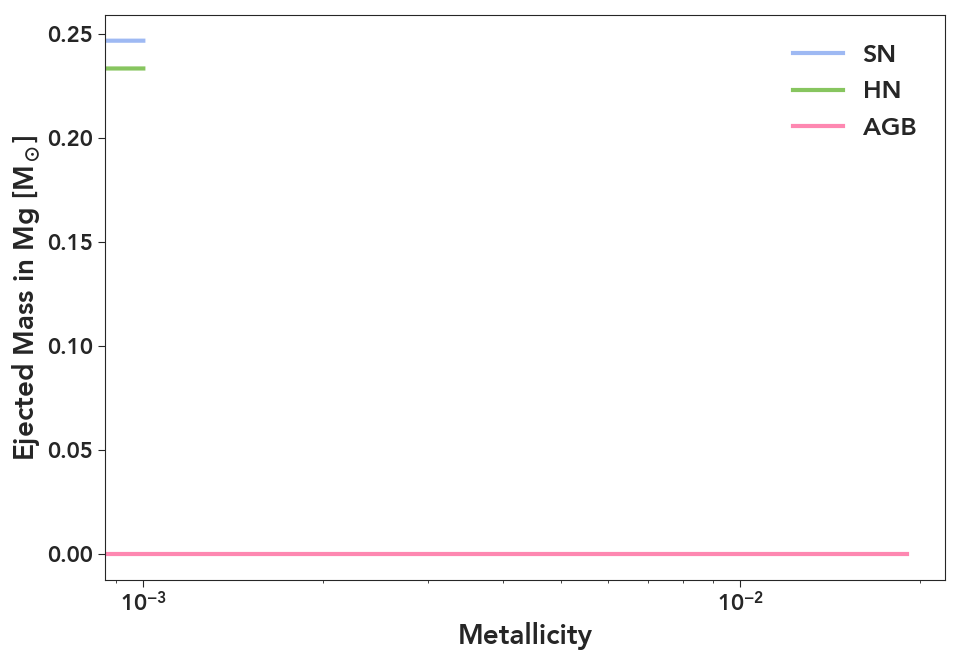

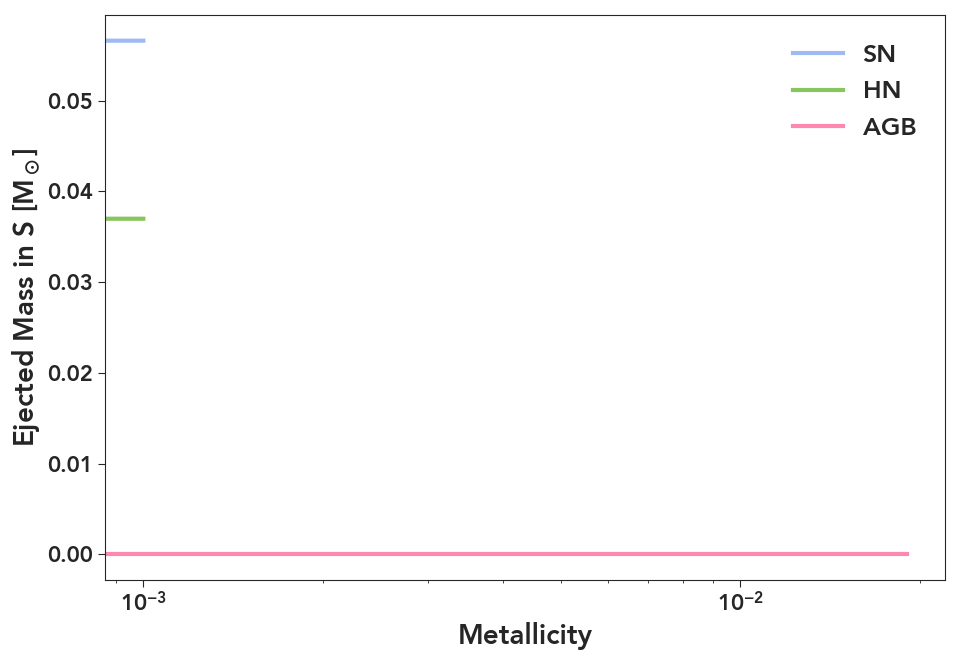

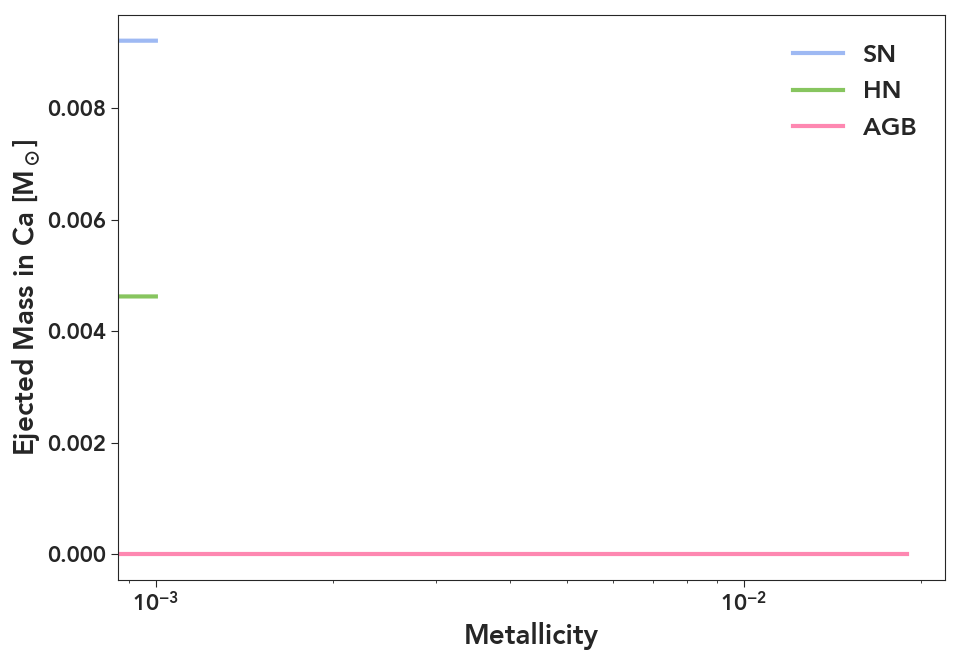

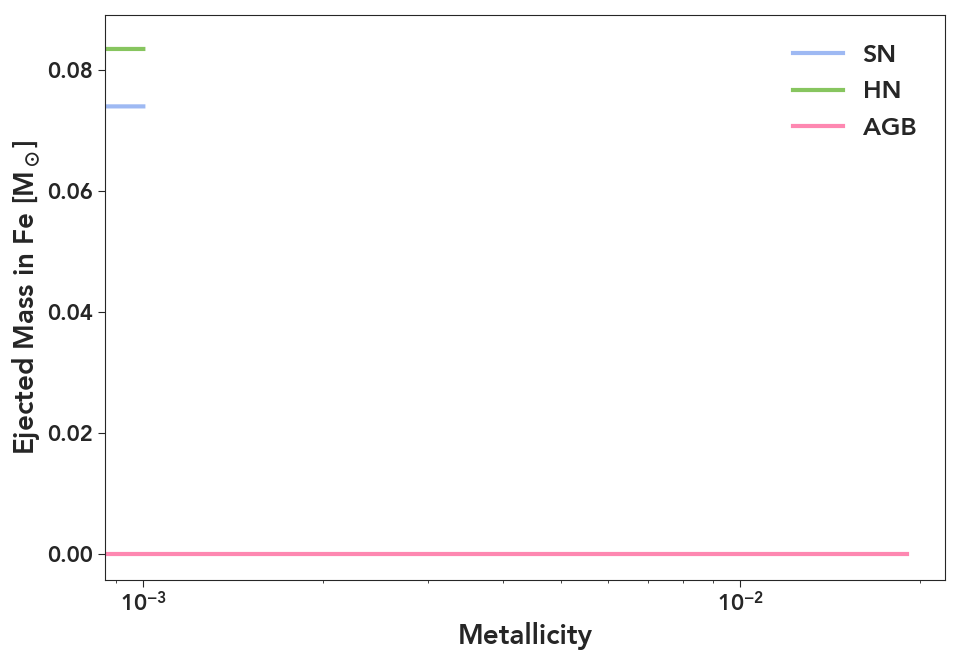

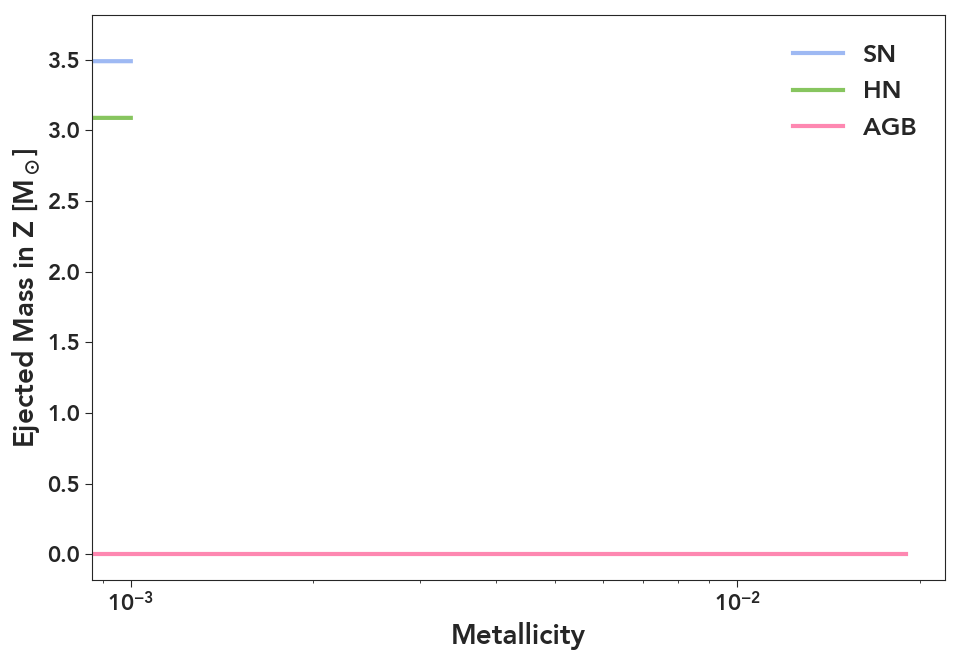

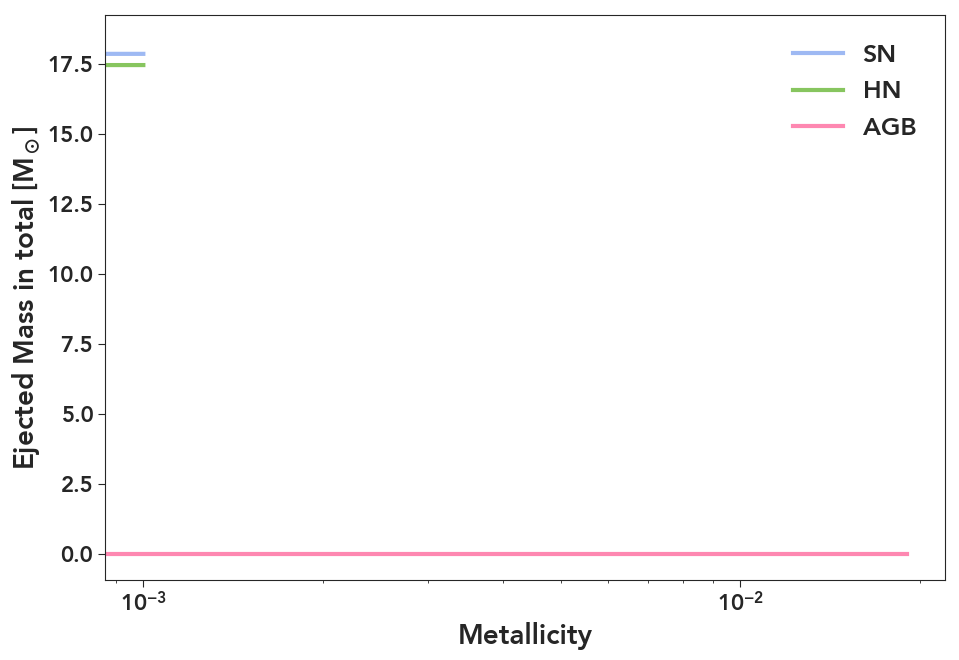

In [49]:
m = 20
zs = np.arange(0, 0.02, 0.001)
for elt in elts:
    fig, ax = bpl.subplots()
    for func, label in zip([tab.get_yields_raw_sn_ii_py,
                            tab.get_yields_raw_hn_ii_py,
                            tab.get_yields_raw_agb_py], 
                           ["SN", "HN", "AGB"]):
        yields = [func(z, m)[field_idxs[elt]] for z in zs]
        
#         for y, z in zip(yields, zs):
#             print(z, y)
        ax.plot(zs, yields, label=label)
    
    ax.add_labels("Metallicity", "Ejected Mass in {}".format(elt) + " [$M_\odot$]")
    ax.set_xscale("log")
#     ax.set_yscale("log")
    ax.legend()

# Test extrapolation

In [38]:
m = 1.3
print(tab.find_mass_bound_idxs_sn_ii_py(m)[0])
print(tab.find_mass_bound_idxs_sn_ii_py(m)[1])
print(tab.find_mass_bound_idxs_hn_ii_py(m)[0])
print(tab.find_mass_bound_idxs_hn_ii_py(m)[1])
print(tab.find_mass_bound_idxs_agb_py(m)[0])
print(tab.find_mass_bound_idxs_agb_py(m)[1])

0
0
0
0
0
1


In [41]:
z = 0.015
print(tab.find_z_bound_idxs_sn_ii_py(z)[0])
print(tab.find_z_bound_idxs_sn_ii_py(z)[1])
# print(tab.find_z_bound_idxs_hn_ii_py(z)[0])
# print(tab.find_z_bound_idxs_hn_ii_py(z)[1])
print(tab.find_z_bound_idxs_agb_py(z)[0])
print(tab.find_z_bound_idxs_agb_py(z)[1])

2
3
3
4


In [29]:
for m in np.arange(40, 50, 1):
    print(tab.extrapolate_py(m, 40, 11.3629))

11.3629
11.646972499999999
11.931045000000001
12.2151175
12.49919
12.7832625
13.067334999999998
13.3514075
13.63548
13.9195525
